# Библиотеки

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from math import *
# from iminuit import Minuit
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
%pylab inline
import warnings
from scipy import stats
from scipy.integrate import quad
import plotly.express as px
from scipy import stats
from scipy import interpolate
import torch.utils.data as data_utils
warnings.filterwarnings('ignore')
plt.rcParams['font.size']=15
from google.colab import drive

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from torchvision.io import read_image
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mp=1.001
mN=14.007
mFe=55.845
m=np.array([mp,mN,mFe])
ln_m=np.log(m+1)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['isinf', 'sin', 'inf', 'fabs', 'frexp', 'prod', 'isfinite', 'nextafter', 'exp', 'log1p', 'e', 'sinh', 'gamma', 'log', 'tanh', 'ceil', 'cosh', 'gcd', 'hypot', 'ldexp', 'pi', 'expm1', 'log2', 'tan', 'nan', 'degrees', 'floor', 'cos', 'fmod', 'log10', 'lcm', 'modf', 'radians', 'copysign', 'remainder', 'isnan', 'trunc', 'isclose', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Функции

In [2]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  def display(self,groups = None):
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)


def get_correct_count(pred, labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted == labels).sum().item()

@torch.inference_mode()
def calaculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        video,imgs, labels = batch
        video=video.to(device)
        imgs=imgs.to(device)
        labels=labels.to(device)
        batch_size_acc=len(labels)
        pred = model(video,imgs,batch_size_acc)
        loss += criterion(pred, labels)
        correct += get_correct_count(pred,labels)
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

def calaculate_mae(model, data_loader, criterion ):
    correct, total = 0, 0
    loss = 0
    val_mae=0
    for batch in data_loader:
        video,imgs, labels = batch
        video=video.to(device)
        imgs=imgs.to(device)
        labels=labels.to(device)
        batch_size_acc=len(labels)
        pred = model(video,imgs,batch_size_acc)
        loss += criterion(pred, labels)
        # correct += get_correct_count(pred,labels)
        mae_loss=nn.L1Loss()
        epoch_mae=mae_loss(pred, labels)/batch_size_acc
        val_mae+=epoch_mae
        # correct += get_correct_count(pred,labels)
        total += labels.size(0)

    return val_mae/ len(data_loader)    , loss.item() / len(data_loader)

# Загрузка данных

In [3]:
from ast import Pass
drive.mount('/content/drive')
direct_q1='drive/MyDrive/data_sphere/data_to_NN/q1_900_10PeV_10-20/'
direct_q2='drive/MyDrive/data_sphere/data_to_NN/q2_900_10PeV_10-20/'

data_direct=[direct_q1+'glob_array_p_q1.npy',direct_q1+'glob_array_Fe_q1.npy',\
             direct_q2+'glob_array_p_q2.npy',direct_q2+'glob_array_Fe_q2.npy']
map_direct=[direct_q1+'map2_p_q1.npy',direct_q1+'map2_Fe_q1.npy',\
             direct_q2+'map2_p_q2.npy',direct_q2+'map2_Fe_q2.npy']

border=1200   # граница числа фотонов, если их в сумме зарегистрировалось меньше в одном событии, то такое событие не рассматривается.
data_all,data_2D,data_y=[],[],[]
target_num=[0,1,0,1]
for i in range(4):

    particle_data=np.load( data_direct[i])
    particle_data=particle_data.reshape(6000,1,50,11,11)

    # Обрезаем данные
    bool_mask=[sum(particle_data[i])<border for i in range(6000)]
    particle_data=particle_data[~np.array(bool_mask)]
    particle_data = particle_data[:,:50]
    print(particle_data.min() ,particle_data.max())

    map2D=np.load( map_direct[i])
    map2D=map2D.reshape(6000,2,11,11)
    map2D=map2D[~np.array(bool_mask)]
    print(map2D.min(),map2D.max())

    data_all.append(particle_data)
    data_2D.append(map2D)
    data_y.append([target_num[i]]*particle_data.shape[0])    # В качетсве y целые числа, 0, 1, 2

    print(particle_data.shape)

if len(data_all)==4:
    data_video=np.concatenate([data_all[0],data_all[1],data_all[2],data_all[3]])
    data_map = np.concatenate([data_2D[0],data_2D[1],data_2D[2],data_2D[3]])
    data_y=np.concatenate([data_y[0],data_y[1],data_y[2],data_y[3]])
    print('data video = ',data_video.shape,',  data map = ',data_map.shape,',  data y = ',data_y.shape)
data_video=(data_video-data_video.min())/(data_video.max()-data_video.min())   # Нормализация данных по кол-ву фотонов в ФЭУ в видео
data_map=(data_map-data_map.min())/(data_map.max()-data_map.min())  # Нормализация данных по кол-ву фотонов в ФЭУ в карте

Mounted at /content/drive
0.0 483.0
0.0 1667.1000000000058
(4271, 1, 50, 11, 11)
0.0 169.0
0.0 1503.0
(3213, 1, 50, 11, 11)
0.0 499.0
0.0 1672.300000000003
(4261, 1, 50, 11, 11)
0.0 168.0
0.0 1700.8999999999942
(3235, 1, 50, 11, 11)
data video =  (14980, 1, 50, 11, 11) ,  data map =  (14980, 2, 11, 11) ,  data y =  (14980,)


In [4]:
# Нормировка видео в каждом событии по максимуму
video_norm_each=np.array([data_video[i][0] for i in range(data_video.shape[0])])

In [15]:
# Нормировка карты суммарных сигналов в каждом событии по максимуму
map_0_norm_each=[data_map[i][0] for i in range(data_map.shape[0])]
map_time=[data_map[i][1] for i in range(data_map.shape[0])]
maps_norm=np.array(list(zip(map_0_norm_each,map_time)))

In [16]:

X= video_norm_each
X = X.reshape(X.shape[0], 1, 50, 11, 11)
print( 'X shape = ', X.shape)

y=data_y
print( 'y shape = ', y.shape)

X_concat=np.asarray(list(zip(X,maps_norm)), dtype = 'object')

print(X_concat.shape)
print(X_concat[0,0].shape)
print(X_concat[0,1].shape)

X shape =  (14980, 1, 50, 11, 11)
y shape =  (14980,)
(14980, 2)
(1, 50, 11, 11)
(2, 11, 11)


Создаем X из video и map, а также y

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_concat, y, test_size=0.3, stratify = y, random_state=42, shuffle=True)

In [28]:
uniq,counts=np.unique(y_test,return_counts=True)
dict(zip(uniq,counts))

{0: 2560, 1: 1934}

In [29]:
class CustomDataset(Dataset):
    def __init__(self, X,y):
        self.X = X[:,0]
        self.map=X[:,1]
        self.y=y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        video = torch.tensor(np.float32(self.X[idx]))
        imgs = torch.tensor(np.float32(self.map[idx]))
        label=torch.tensor(np.float32(self.y[idx])).type(torch.LongTensor)  # для классификации, ибо LongTensor равносильно int()

        return video, imgs, label

batch_size=64
train_dataset=CustomDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset=CustomDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Архитектура сети

In [30]:
import tensorflow
# from tensorflow import keras
# from tensorflow.keras import layers
from tensorflow.keras.layers import SeparableConv2D
# x = SeparableConv2D(64, (1, 16), use_bias = False, padding = 'same')(x)

class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                  groups=in_channels, bias=bias, padding=1)
        self.pointwise = nn.Conv2d(in_channels, out_channels,
                                  kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv3d(1, 32, (2,1,1), stride=(4,1,1), padding=0)
        self.conv2 = nn.Conv3d(32, 16, (2,1,1), stride=(4,1,1), padding=0)
        self.conv3 = nn.Conv3d(16, 8, (3,1,1), stride=(1,1,1), padding=0)

        self.fc1 = nn.Linear(11*11*10, 11*11*4)
        self.fc2 = nn.Linear(11*11*4, 3)

    def forward(self, video,imgs,batch_size_nn=2):
        video = F.relu(self.conv1(video))
        video = F.relu(self.conv2(video))
        video = F.relu(self.conv3(video))
        video = video.view(batch_size_nn,8, 11, 11)
        # x=video

        x = torch.cat((video, imgs), dim=1)      # Получили размерность (10,11,11)
        x = torch.flatten(x,1)

        x= self.fc1(x)
        x= self.fc2(x)

        return x

# **Основной цикл обучения.**

In [32]:
def train(model, criterion, optimizer, num_epochs=5):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total, ep_loss = 0, 0, 0
        epochs_mae=0
        for i, data in enumerate(train_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, imgs, labels = data
          inputs=inputs.to(device)
          imgs=imgs.to(device)
          labels=labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          batch_size_nn=len(labels)
          # forward + backward + optimize
          outputs = model(inputs,imgs,batch_size_nn)
          loss = criterion(outputs, labels)
          correct += get_correct_count(outputs, labels)

          loss.backward()
          optimizer.step()

          total += labels.size(0)
          ep_loss += loss.item()

          # print statistics
          running_loss += loss.item()
          if i % 500 == 499:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
        # print('imgs shape ',imgs.shape)
        scheduler.step(loss)
        # Logging
        pp.add_scalar('loss_train', ep_loss / len(train_dataloader))
        pp.add_scalar('accuracy_train', correct/total)
        accuracy, loss_val = calaculate_accuracy(model,test_dataloader,criterion)
        pp.add_scalar('accuracy_val',accuracy)
        pp.add_scalar('loss_val',loss_val)

        # pp.display([['loss_train'],['mae_train']])
        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])

    # del x,target,loss,outputs
    return pp

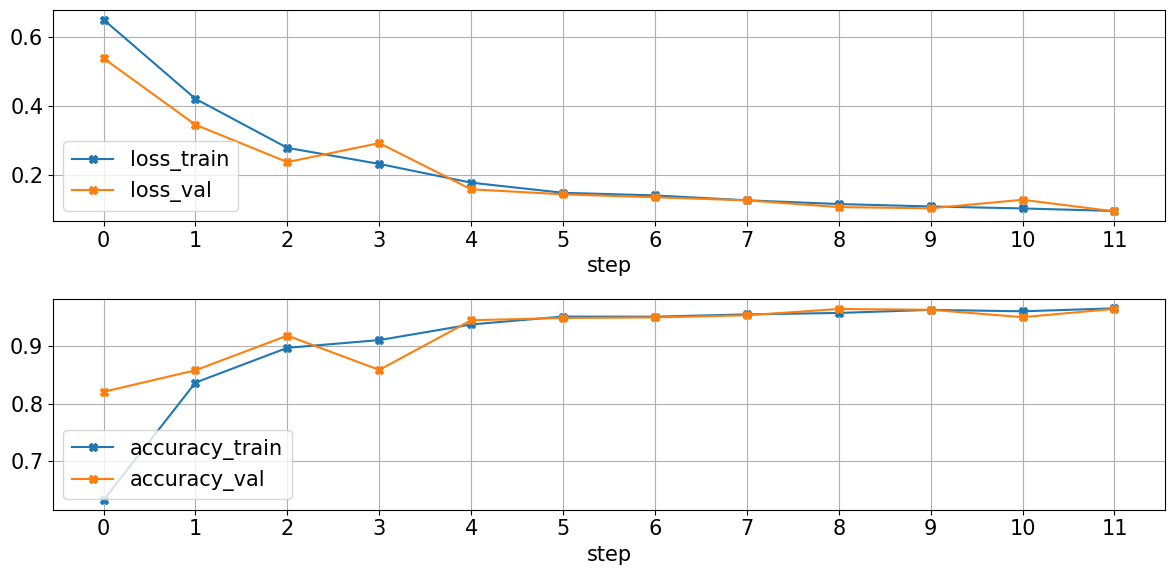

In [33]:
model = Net().to(device)  # Create model instance
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)  #, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=20)
criterion = nn.CrossEntropyLoss().to(device) # Loss function
pp = train(model, criterion, optimizer, num_epochs=12)

# Точность классификации

In [34]:
classes=['p','Fe']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
p_as_Fe, Fe_as_p = 0, 0
# again no gradients needed
with torch.no_grad():
    pred_save=[]
    for data in test_dataloader:
        video,images, labels = data
        video,images, labels=video.to(device),images.to(device), labels.to(device)
        batch_size_prov=len(labels)
        outputs = model(video,images,batch_size_prov)
        _, predictions = torch.max(outputs, 1)
        pred_save.append(predictions.tolist())
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            if label==0 and prediction==1:
                p_as_Fe+=1
            if label==1 and prediction==0:
                Fe_as_p+=1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: p     is 95.2 %
Accuracy for class: Fe    is 98.1 %


Accuracy for class: p     is 95.2 %

Accuracy for class: Fe    is 98.1 %

# Визуализация результатов классификации. Сравнение с экспериментом Pierre Auger

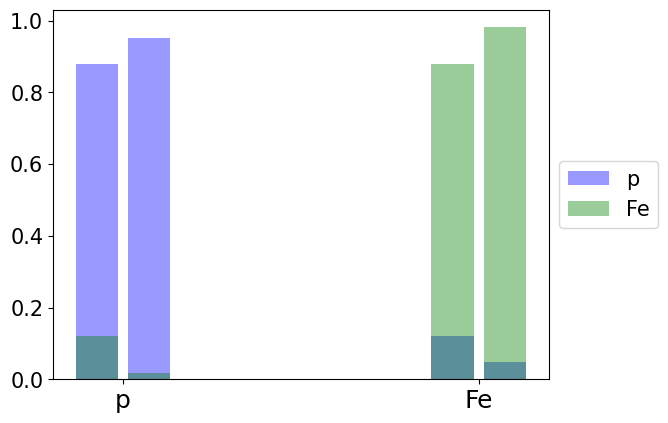

In [50]:
# Данные после классификации нейронной сетью
sum_p = correct_pred['p'] + p_as_Fe
sum_Fe = correct_pred['Fe'] + Fe_as_p
y_nn=[[correct_pred['p']/sum_p,p_as_Fe/sum_p],[Fe_as_p/sum_Fe,correct_pred['Fe']/sum_Fe]]

# Данные из статьи Kalashev O. et al // Neural Networks as a Composition Diagnostic for
# Ultra-high Energy Cosmic Rays // Journal of Instrumentation, V 17, P05008, 2022
pp=0.88
FeFe = 0.88
pro_as_Fe = 1-pp
Fe_as_pro = 1-FeFe
y_2core=[[pp,pro_as_Fe],[Fe_as_pro,FeFe]]

x=np.arange(1-0.11,4-0.11,1.5)
x_nn=np.arange(1+0.11,4+0.11,1.5)
col3=['blue','green']
width=0.18
name=['p','Fe']
fig,ax=plt.subplots()
for i in range(2):
    ax.bar(x,y_2core[i],alpha=0.4,color=col3[i],width=width,label=name[i])
    ax.bar(x_nn,y_nn[i],width=width,alpha=0.4,color=col3[i])
ax.set_xticks(np.arange(1,4,1.5))
ax.set_xticklabels(['p','Fe'], fontsize=18)
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.savefig('percent_2core_NN.png',bbox_inches='tight')

Вероятность определения ядер. Цветом обозначено истинное ядро, а по оси абсцисс предсказываемое. Левее от подписей оси OХ показаны результаты команды Pierre Auger [22], правее результаты классификации нейронной сети